<h1 style="font-size:2em">Projet 7 - Implémentez un modèle de scoring</h1>


# Tracking MLflow

## Imports et configs

In [1]:
# !pip install -r ../../requirements.txt

In [1]:
# Librairies principales
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [2]:
# Librairies secondaires

# Gestion des données et prétraitement
import gc
import time
import joblib
from sklearn.preprocessing import StandardScaler

# Modèles et algorithmes
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

# Validation croisée et sélection de modèles
from sklearn.model_selection import StratifiedKFold, cross_val_predict
import optuna

# Évaluation et métriques
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    roc_curve,
)

# Suivi des expériences
import mlflow
import mlflow.sklearn

# Gestion de warnings et logs
import logging
import warnings
from sklearn.exceptions import ConvergenceWarning

In [3]:
# Configuration graphique

sns.set_theme(
    style='whitegrid',
    palette='pastel',
    font='helvetica',
    font_scale=1.1,
    rc={
        'text.color': 'black',
        'axes.labelcolor': 'black',
        'xtick.color': 'black',
        'ytick.color': 'black',
        'grid.color': 'gray',
        'grid.linestyle': '--',
        'grid.alpha': 0.3,
        'axes.edgecolor': 'black',
        'axes.spines.left': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'axes.spines.bottom': False
    }
)

def remove_spines(ax):
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

palette = sns.color_palette()

In [4]:
df = pd.read_csv('df.csv', sep = ",")

FileNotFoundError: [Errno 2] No such file or directory: 'df.csv'

In [5]:
print(df.shape)
df.head()

NameError: name 'df' is not defined

In [34]:
definition_colonnes = pd.read_csv('../../Datasets/HomeCredit_columns_description.csv', encoding='ISO-8859-1')

In [35]:
definition_colonnes[definition_colonnes["Row"] == "TARGET"]

,Unnamed: 0,Table,Row,Description,Special
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN


- TARGET = **1** -> Client **AVEC** des difficultés de payments
- TARGET = **0** -> Client **SANS** difficultés de payments

### Définir la stratégie d’élaboration d’un modèle d’apprentissage supervisé, et sélectionner et entraîner des modèles adaptés à une problématique métier afin de réaliser une analyse prédictive.

#### CE1 Vous avez défini sa stratégie d’élaboration d’un modèle pour répondre à un besoin métier

**Le modèle doit respecter le cahier des charges suivant:**
- Le déséquilibre entre le nombre de bons et de moins bons clients (class_weight)
- Les scores à considérer sont les suivants:
    - AUC (Area Under the Curve) < 0.82
    - Accuracy
    - Score "métier" (le coût d’un FN est dix fois supérieur au coût d’un FP)
- On utilisera de la Cross-Validation
- Trouver le bon seuil "predict" (défault = 0.5)

### Définition Accuracy

Accuracy = Ratio entre le nombre de prédiction juste et le nombre de prédiction totaux

### Définition AUC (Area Under the Curve)

Se base sur la courbe ROC (Receiver-Operator Characteristic):
- Axe des X (Taux de faux positifs)
- Axe des Y (Taux de vrais positifs)
- La courbe est cré à partir de différents seuils de classification
- **AUC** est l'aire sous la courbe, elle vaut 1 pour un modèle parfait

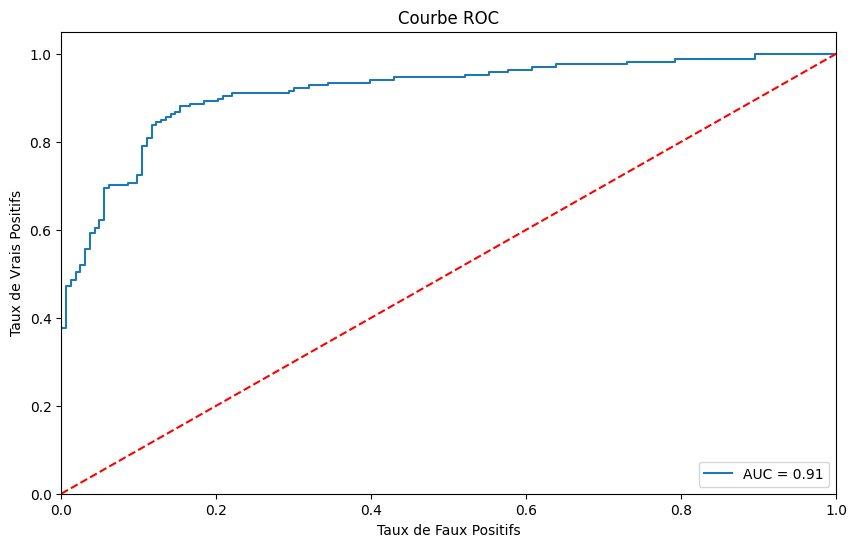

### Définition Score "métier"

*le coût d’un FN est dix fois supérieur au coût d’un FP*

## CE2 Vous avez choisi la ou les variables cibles pertinentes.

La variable cible est le "TARGET" 

## CE3 Vous avez vérifié qu'il n’y a pas de problème de data leakage (c'est-à-dire, des variables trop corrélées à la variable cible et inconnues a priori dans les données en entrée du modèle).

On utilisera les "features importances" pour vérifier si on n'a pas de data leakage

## CE4 Vous avez testé plusieurs algorithmes de façon cohérente, en partant des plus simples vers les plus complexes (au minimum un linéaire et un non linéaire).

Le dataset df contient des NaN:
- Linéaire -> Régression logistique (Obligé d'effectuer une imputation)
- Non Linéaire -> LightGBM (marche très bien pour un dataframe avec des NaN)
- Dummy -> dummyClassifier (Obligé d'effectuer une imputation)

# Évaluer les performances des modèles d’apprentissage supervisé selon différents critères (scores, temps d'entraînement, etc.) en adaptant les paramètres afin de choisir le modèle le plus performant pour la problématique métier.

## Déséquilibre entre le nombre de bons et de moins bons clients

Nombre de 0: 282682
Nombre de 1: 24825


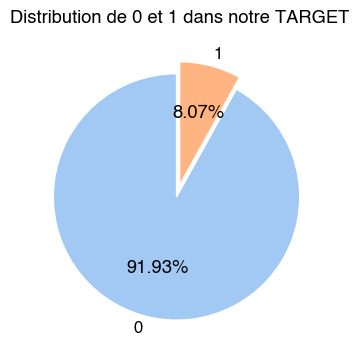

In [36]:
# Supprimer les NaN
df_clean = df['TARGET'].dropna()

# Compter le nombre de 0 et 1
count_0 = (df_clean == 0).sum()
count_1 = (df_clean == 1).sum()

# Créer les variables pour le nombre de 0 et 1
nb_0 = count_0
nb_1 = count_1

print(f"Nombre de 0: {nb_0}")
print(f"Nombre de 1: {nb_1}")

# Calculer les pourcentages
total = len(df_clean)
percentage_0 = (nb_0 / total) * 100
percentage_1 = (nb_1 / total) * 100

# Créer le pie plot
plt.figure(figsize=(4, 4)) 
labels = ['0', '1']
values = [nb_0, nb_1]
plt.pie(
    values,
    labels=labels,
    autopct=lambda p: f'{p:.2f}%',  # Format des pourcentages
    startangle=90,  # Angle de démarrage
    explode=(0.1, 0)  # Séparer légèrement la catégorie '0'
)

plt.title('Distribution de 0 et 1 dans notre TARGET')
plt.show()

On a énormément de 0 (plus de 91% du total), il va falloir en prendre en compte dans nos modèles

In [8]:
df_classification = df[df['TARGET'].notnull()]
df_classification.shape

(307507, 773)

**Création df_classification_imputed (stratégie: Moyenne)**

In [9]:
df_classification_imputed = df_classification.copy()
df_classification_imputed.fillna(df_classification.mean(), inplace=True)

## DummyClassifer

In [ ]:
mlflow.set_tracking_uri("../mlruns")  # Chemin relatif vers le dossier mlruns

In [11]:
# 1. Prétraiter les données
X = df_classification_imputed.drop(columns=["TARGET", "SK_ID_CURR"])
y = df_classification_imputed["TARGET"]

# 2. Préparer la Cross-Validation
cv = StratifiedKFold(n_splits=5)

# Hyperparamètres du DummyClassifier
strategies = ['stratified', 'most_frequent', 'prior', 'uniform', 'constant']

results = []

mlflow.set_experiment("DummyClassifier")

for strategy in strategies:
    with mlflow.start_run():
        dummy = DummyClassifier(strategy=strategy, constant=1 if strategy == 'constant' else None)

        # Mesurer le temps de traitement de fit
        start_time_fit = time.time()
        dummy.fit(X, y)
        elapsed_time_fit = time.time() - start_time_fit

        # Mesurer le temps de traitement de prédiction
        start_time_predict = time.time()
        y_prob = cross_val_predict(dummy, X, y, cv=cv, method="predict_proba")[:, 1]
        elapsed_time_predict = time.time() - start_time_predict
        
        y_pred = (y_prob > 0.5)

        # Calcul des scores
        auc = roc_auc_score(y, y_prob)
        acc = accuracy_score(y, y_pred)
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
        cost = fp + 10 * fn

        # Log les hyperparamètres, métriques et temps à MLflow
        mlflow.log_param("Strategy", strategy)
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", acc)
        mlflow.log_metric("Business Score", cost)
        mlflow.log_metric("Fit Time", elapsed_time_fit)
        mlflow.log_metric("Prediction Time", elapsed_time_predict)

        # Log le modèle à MLflow
        mlflow.sklearn.log_model(dummy, "dummy_model")

        # Stockage et log des courbes ROC
        fpr, tpr, thresholds = roc_curve(y, y_prob)
        
        plt.figure(figsize=(10, 7))
        plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.savefig("roc_curve.png")
        plt.close()
        mlflow.log_artifact("roc_curve.png")
        
        # Ajouter les résultats à la liste
        results.append({
            "Strategy": strategy,
            "AUC": auc,
            "Accuracy": acc,
            "Business Score": cost
        })

# Afficher les résultats
results_df = pd.DataFrame(results)

gc.collect()

2024/12/02 10:51:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/02 10:51:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/02 10:51:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/02 10:51:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/02 10:51:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


117

In [12]:
styled_df_Dummy = results_df.sort_values(by='Business Score', ascending=True)

In [13]:
styled_df_Dummy .to_csv('results_Dummy.csv', index=False)

In [19]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]

def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: lightgreen' if v else '' for v in is_min]

# Appliquer le style directement
styled_df_Dummy = (
    results_df.sort_values(by='Business Score', ascending=True)
    .style.apply(highlight_max, subset=['AUC', 'Accuracy'])
    .apply(highlight_min, subset=['Business Score'])
    .format({"Threshold": "{:.2g}"})  # Si une colonne "Threshold" est présente
)

# Afficher le tableau stylé
styled_df_Dummy

,Strategy,AUC,Accuracy,Business Score
1,most_frequent,0.500000,0.919270,248250
2,prior,0.499998,0.919270,248250
3,uniform,0.500000,0.919270,248250
0,stratified,0.499189,0.851304,251438
4,constant,0.500000,0.080730,282682


Le DummyClassifier génère des prédictions en fonction de sa stratégie, et non en fonction d'une probabilité qui varie avec le seuil

## Régression logistique

In [22]:
warnings.simplefilter('ignore', ConvergenceWarning)
optuna_logger = logging.getLogger('optuna')
optuna_logger.setLevel(logging.CRITICAL)

start_time = time.time()

# Configuration initiale de MLflow
mlflow.set_experiment('Logistic_Regression')

nb_0 = (df_classification_imputed['TARGET'] == 0).sum()
nb_1 = (df_classification_imputed['TARGET'] == 1).sum()

X = df_classification_imputed.drop(columns=["TARGET", "SK_ID_CURR"])
y = df_classification_imputed["TARGET"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

cv = StratifiedKFold(n_splits=5)
class_weights = {0: 1, 1: nb_0 / nb_1}

results = []

total_combinations = 50 

def objective(trial):
    C_val = trial.suggest_float('C_val', 50, 200)
    threshold = trial.suggest_float('threshold', 0.4, 0.6, step=0.01)

    model = LogisticRegression(C=C_val, class_weight=class_weights, verbose=0, max_iter=1000)
    
    # Enregistrement du temps de début pour le fit
    start_fit_time = time.time()
    y_prob = cross_val_predict(model, X, y, cv=cv, method="predict_proba")[:, 1]
    # Calculer le temps de fit
    fit_duration = time.time() - start_fit_time

    # Enregistrement du temps de début pour la prédiction
    start_pred_time = time.time()
    y_pred = y_prob > threshold
    # Calculer le temps de prédiction
    pred_duration = time.time() - start_pred_time

    auc = roc_auc_score(y, y_prob)
    acc = accuracy_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    cost = fp + 10 * fn
    
    results.append({
        "C": C_val,
        "Threshold": threshold,
        "AUC": auc,
        "Accuracy": acc,
        "Business Score": cost
    })

    with mlflow.start_run():
        mlflow.log_param("C", C_val)
        mlflow.log_param("Threshold", round(threshold, 2))
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", acc)
        mlflow.log_metric("Business Score", cost)
        
        # Enregistrer les temps dans mlflow
        mlflow.log_metric("Fit Time", fit_duration)
        mlflow.log_metric("Prediction Time", pred_duration)

        fpr, tpr, _ = roc_curve(y, y_prob)
        plt.figure(figsize=(10, 7))
        plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.savefig("roc_curve.png")
        plt.close()
        mlflow.log_artifact("roc_curve.png")

        mlflow.sklearn.log_model(model, "model")

    gc.collect()

    return cost

def print_progress(study, trial, total_combinations):
    print(f"Essai {trial.number + 1}/{total_combinations} terminé!", end='\r', flush=True)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=total_combinations, callbacks=[lambda study, trial: print_progress(study, trial, total_combinations)])

results_df = pd.DataFrame(results)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTemps écoulé: {elapsed_time:.2f} secondes")

print(study.best_params)

2024/12/02 11:52:29 INFO mlflow.tracking.fluent: Experiment with name 'Logistic_Regression' does not exist. Creating a new experiment.
2024/12/02 11:55:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 11:58:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 12:01:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 12:04:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 12:06:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 12:09:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 12:12:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 12:14:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 12:17:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 12:20:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 12:22:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 12:25:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 12:27:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 12:31:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 12:34:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 12:36:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 12:39:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 12:41:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 12:44:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 12:47:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 12:50:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 12:53:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 12:56:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 12:59:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 13:01:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 13:04:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 13:07:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 13:10:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 13:13:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 13:15:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 13:18:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 13:21:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 13:23:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 13:26:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 13:29:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 13:31:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 13:34:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 13:36:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 13:39:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 13:41:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 13:44:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 13:47:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 13:50:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 13:52:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 13:55:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 13:58:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 14:01:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 14:03:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 14:20:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 14:25:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Essai 50/50 terminé!
Temps écoulé: 9198.13 secondes
{'C_val': 115.86647530320963, 'threshold': 0.51}


In [23]:
styled_df_Log_Reg = results_df.sort_values(by='Business Score', ascending=True)

In [24]:
styled_df_Log_Reg.to_csv('results_Log_Reg.csv', index=False)

In [38]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]

def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: lightgreen' if v else '' for v in is_min]

styled_df_Log_Reg  = (styled_df_Log_Reg.style.apply(highlight_max, subset=['AUC', 'Accuracy'])
                          .apply(highlight_min, subset=['Business Score'])
                          .format({'Threshold': "{:g}", 'Business Score': "{:.0f}"}))

styled_df_Log_Reg 

,C,Threshold,AUC,Accuracy,Business Score
0,115.866475,0.51,0.771688,0.718904,156711
1,141.028782,0.52,0.771713,0.728725,156733
2,135.871537,0.52,0.771718,0.728650,156738
3,124.751872,0.54,0.771710,0.747902,156740
4,119.583960,0.54,0.771692,0.747983,156769
5,98.853770,0.52,0.771726,0.728696,156805
6,115.609336,0.54,0.771650,0.747892,156806
7,86.284591,0.53,0.771674,0.738321,156815
8,94.140037,0.53,0.771685,0.738243,156839
9,130.370090,0.52,0.771642,0.728696,156841


**On va plot les features importances:**

In [26]:
study.best_params

{'C_val': 115.86647530320963, 'threshold': 0.51}

**On va plot les features importances:**

In [27]:
# Supposition que df_classification_imputed est déjà défini
nb_0 = len(df_classification_imputed[df_classification_imputed["TARGET"] == 0])
nb_1 = len(df_classification_imputed[df_classification_imputed["TARGET"] == 1])
class_weights = {0: 1, 1: nb_0 / nb_1}

X = df_classification_imputed.drop(columns=["TARGET", "SK_ID_CURR"])
y = df_classification_imputed["TARGET"]

# Stockage des noms des colonnes pour utilisation ultérieure
feature_names = X.columns

# Standardisation des données
scaler = StandardScaler()
X = scaler.fit_transform(X)  

# Remplacer 'C_val' par 'C'
params = study.best_params.copy()
params['C'] = params.pop('C_val')

# Suppression de 'threshold'
params.pop('threshold', None)

# Instanciation du modèle
clf = LogisticRegression(**params, class_weight=class_weights, max_iter=1000, verbose = 1)

# Validation croisée
cv = StratifiedKFold(n_splits=5)
feature_importances = np.zeros(X.shape[1])

for train, test in cv.split(X, y):
    clf.fit(X[train], y.iloc[train])
    # Pour la régression logistique, l'importance des caractéristiques est donnée par les coefficients
    feature_importances += np.abs(clf.coef_[0])

# Moyenne des importances de caractéristiques sur les plis
feature_importances /= 5

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          772     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.47149D-01


 This problem is unconstrained.



At iterate   50    f=  5.65283D-01    |proj g|=  3.97328D-03

At iterate  100    f=  5.64649D-01    |proj g|=  8.20877D-04

At iterate  150    f=  5.64413D-01    |proj g|=  3.44697D-04

At iterate  200    f=  5.64298D-01    |proj g|=  3.42880D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  772    245    257      1     0     0   9.933D-05   5.642D-01
  F =  0.56424836998183103     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          772     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   50    f=  5.64921D-01    |proj g|=  9.16576D-04

At iterate  100    f=  5.64354D-01    |proj g|=  3.81612D-04

At iterate  150    f=  5.64169D-01    |proj g|=  2.17617D-04

At iterate  200    f=  5.64065D-01    |proj g|=  1.71362D-04

At iterate  250    f=  5.64007D-01    |proj g|=  1.10800D-04

At iterate  300    f=  5.63957D-01    |proj g|=  1.55535D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  772    318    334      1     0     0   8.833D-05   5.639D-01
  F =  0.56394077892024386     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   50    f=  5.64468D-01    |proj g|=  8.92677D-04

At iterate  100    f=  5.63836D-01    |proj g|=  5.09377D-04

At iterate  150    f=  5.63600D-01    |proj g|=  4.30578D-04

At iterate  200    f=  5.63477D-01    |proj g|=  1.63899D-04

At iterate  250    f=  5.63412D-01    |proj g|=  1.66610D-04

At iterate  300    f=  5.63347D-01    |proj g|=  1.68180D-04

At iterate  350    f=  5.63290D-01    |proj g|=  2.61725D-04

At iterate  400    f=  5.63238D-01    |proj g|=  2.83349D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  772    445    472      1     0     0   9.327D-05   5.632D-01
  F =  0.563200088214

 This problem is unconstrained.



At iterate   50    f=  5.65852D-01    |proj g|=  9.66604D-04

At iterate  100    f=  5.65348D-01    |proj g|=  2.70195D-04

At iterate  150    f=  5.65190D-01    |proj g|=  2.50796D-04

At iterate  200    f=  5.65087D-01    |proj g|=  5.22193D-04

At iterate  250    f=  5.65024D-01    |proj g|=  1.85486D-04

At iterate  300    f=  5.64947D-01    |proj g|=  1.48084D-04

At iterate  350    f=  5.64892D-01    |proj g|=  1.13120D-04

At iterate  400    f=  5.64848D-01    |proj g|=  1.50262D-04

At iterate  450    f=  5.64798D-01    |proj g|=  1.08663D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  772    462    488   

 This problem is unconstrained.



At iterate   50    f=  5.66205D-01    |proj g|=  1.14216D-03

At iterate  100    f=  5.65657D-01    |proj g|=  3.01055D-04

At iterate  150    f=  5.65459D-01    |proj g|=  7.42015D-04

At iterate  200    f=  5.65343D-01    |proj g|=  2.03405D-04

At iterate  250    f=  5.65279D-01    |proj g|=  1.26661D-04

At iterate  300    f=  5.65216D-01    |proj g|=  1.21210D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  772    305    325      1     0     0   9.950D-05   5.652D-01
  F =  0.56521140834736228     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [28]:
df_feature_importances_log_reg = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

df_feature_importances_log_reg = df_feature_importances_log_reg.sort_values(by='importance', ascending=False)
df_feature_importances_log_reg["importance"] = (df_feature_importances_log_reg["importance"]/ df_feature_importances_log_reg["importance"].sum())*100

In [29]:
df_feature_importances_log_reg.to_csv('df_feature_importances_log_reg.csv', index=False)

In [30]:
df_feature_importances_log_reg

,feature,importance
633,INSTAL_AMT_PAYMENT_SUM,2.027562
689,CC_AMT_RECEIVABLE_PRINCIPAL_MAX,1.895228
629,INSTAL_AMT_INSTALMENT_SUM,1.818151
4,AMT_GOODS_PRICE,1.520967
621,INSTAL_PAYMENT_PERC_SUM,1.434560
631,INSTAL_AMT_PAYMENT_MAX,1.434022
619,INSTAL_PAYMENT_PERC_MAX,1.422313
627,INSTAL_AMT_INSTALMENT_MAX,1.378634
377,PREV_AMT_GOODS_PRICE_MAX,1.276726
755,CC_NAME_CONTRACT_STATUS_Demand_SUM,1.246669


In [31]:
Pourcentage_importance_totale = 95

# Sort the dataframe by importance in descending order
df_sorted = df_feature_importances_log_reg.sort_values(by="importance", ascending=False)

# Calculate the cumulative importance
df_sorted["cumulative_importance"] = df_sorted["importance"].cumsum()

# Find the number of features needed to reach 99% of the total importance
num_features = df_sorted[df_sorted["cumulative_importance"] <= df_sorted["importance"].sum() * Pourcentage_importance_totale/100].shape[0]

num_features

474

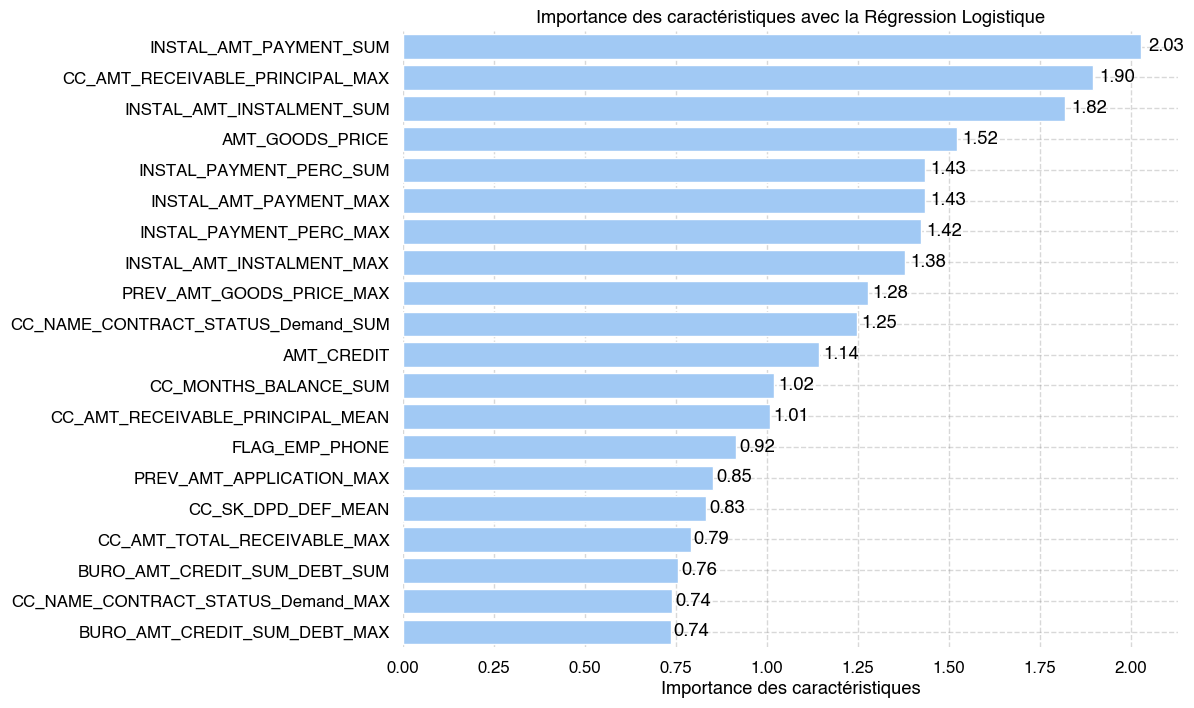

In [32]:
# Extraire les colonnes 'feature' et 'importance' de votre dataframe
features = df_feature_importances_log_reg['feature'].to_numpy()
importances = df_feature_importances_log_reg['importance'].to_numpy()

# Création d'un masque pour les importances supérieures à 0
mask = importances > 0

# Filtrage des features et des importances en utilisant le masque
filtered_feature_names = features[mask]
filtered_feature_importances = importances[mask]

# Supposons que vous vouliez afficher les 10 principales caractéristiques
n_features_to_display = 20

# Tri des indices filtrés par importance
sorted_idx = filtered_feature_importances.argsort()

# Limiter aux n principales caractéristiques
top_n_idx = sorted_idx[-n_features_to_display:]

# Affichage de l'importance des caractéristiques filtrées pour les n principales
plt.figure(figsize=(10, len(top_n_idx) * 0.4))
bars = plt.barh(filtered_feature_names[top_n_idx], filtered_feature_importances[top_n_idx])

# Ajuster les limites de l'axe des y pour réduire l'espace autour des barres
plt.ylim(-0.5, len(top_n_idx)-0.5)

plt.xlabel("Importance des caractéristiques")
plt.title("Importance des caractéristiques avec la Régression Logistique")

# Ajouter les valeurs à côté des barres
for bar in bars:
    width = bar.get_width()
    
    # Déterminez le formatage en fonction de la magnitude
    if width < 0.01:
        fmt = '{:.4f}'
    elif width < 0.1:
        fmt = '{:.3f}'
    else:
        fmt = '{:.2f}'
    
    plt.text(width + 0.01 * width,  # Ajouter un padding proportionnel à la valeur
             bar.get_y() + bar.get_height() / 2,
             fmt.format(width),
             va='center', ha='left')

plt.show()

Apparament, il n'y a pas de problème de data leakage car il n'y a pas de caractéristiques vraiment supérieures relatif aux autres

## LightGBM

L'avantage du LightGBM c'est qu'il marche bien avec des colonnes avec des NaN (on ne dénature pas le dataset avec une imputation)

In [35]:
optuna_logger = logging.getLogger('optuna')
optuna_logger.setLevel(logging.CRITICAL)

start_time = time.time()

# Configuration initiale de MLflow
mlflow.set_experiment('LightGBM')

nb_0 = (df_classification['TARGET'] == 0).sum()
nb_1 = (df_classification['TARGET'] == 1).sum()

X = df_classification.drop(columns=["TARGET", "SK_ID_CURR"])
y = df_classification["TARGET"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

cv = StratifiedKFold(n_splits=5)
class_weights = {0: 1, 1: nb_0 / nb_1}

results = []

total_combinations = 50  # définir cela avant d'appeler study.optimize()

def objective(trial):
    lr = trial.suggest_float('lr', 0.001, 0.1, log=True)
    num_leaves = trial.suggest_int('num_leaves', 31, 70)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
    threshold = trial.suggest_float('threshold', 0.4, 0.6, step=0.01)

    model = LGBMClassifier(learning_rate=lr, num_leaves=num_leaves, n_estimators=n_estimators, class_weight=class_weights, verbose=-1)
    
    # Enregistrement du temps de début pour le fit
    start_fit_time = time.time()
    y_prob = cross_val_predict(model, X, y, cv=cv, method="predict_proba")[:, 1]
    # Calculer le temps de fit
    fit_duration = time.time() - start_fit_time

    # Enregistrement du temps de début pour la prédiction
    start_pred_time = time.time()
    y_pred = y_prob > threshold
    # Calculer le temps de prédiction
    pred_duration = time.time() - start_pred_time

    auc = roc_auc_score(y, y_prob)
    acc = accuracy_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    cost = fp + 10 * fn
    
    results.append({
        "Learning Rate": lr,
        "Num Leaves": num_leaves,
        "Threshold": threshold,
        "AUC": auc,
        "Accuracy": acc,
        "Business Score": cost
    })

    with mlflow.start_run():
        mlflow.log_param("Learning Rate", lr)
        mlflow.log_param("Num Leaves", num_leaves)
        mlflow.log_param("N Estimators", n_estimators) 
        mlflow.log_param("Threshold", round(threshold, 2))
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", acc)
        mlflow.log_metric("Business Score", cost)
        
        # Enregistrer les temps dans mlflow
        mlflow.log_metric("Fit Time", fit_duration)
        mlflow.log_metric("Prediction Time", pred_duration)

        fpr, tpr, _ = roc_curve(y, y_prob)
        plt.figure(figsize=(10, 7))
        plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.savefig("roc_curve.png")
        plt.close()
        mlflow.log_artifact("roc_curve.png")

        mlflow.sklearn.log_model(model, "model")

    gc.collect()

    return cost

def print_progress(study, trial, total_combinations):
    print(f"Essai {trial.number + 1}/{total_combinations} terminé!", end='\r', flush=True)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=total_combinations, callbacks=[lambda study, trial: print_progress(study, trial, total_combinations)])

# 6. Afficher les résultats
results_df = pd.DataFrame(results)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTemps écoulé: {elapsed_time:.2f} secondes")

print(study.best_params)

2024/12/02 14:46:17 INFO mlflow.tracking.fluent: Experiment with name 'LightGBM' does not exist. Creating a new experiment.
2024/12/02 14:52:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 14:53:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 15:01:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 15:02:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 15:08:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 15:11:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 15:15:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 15:20:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 15:22:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 15:25:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 15:27:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 15:29:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 15:31:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 15:33:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 15:34:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 15:37:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 15:40:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 15:44:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 15:47:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 15:52:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 15:55:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 16:00:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 16:07:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 16:11:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 16:15:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 16:21:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 16:28:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 16:38:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 17:18:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 17:26:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 17:33:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 17:58:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 18:06:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 18:15:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 18:27:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 18:34:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 18:45:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 19:07:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 19:30:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 19:38:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 19:49:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 20:03:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 20:16:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 20:28:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 20:36:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 20:45:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 21:01:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 21:10:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 21:19:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2024/12/02 21:29:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Essai 50/50 terminé!
Temps écoulé: 24218.28 secondes
{'lr': 0.014863992368451772, 'num_leaves': 47, 'n_estimators': 721, 'threshold': 0.48000000000000004}


In [36]:
styled_df_LGM = results_df.sort_values(by='Business Score', ascending=True)

In [37]:
styled_df_LGM.to_csv('results_LGM.csv', index=False)

In [40]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]

def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: lightgreen' if v else '' for v in is_min]

styled_df_LGM = (styled_df_LGM.style.apply(highlight_max, subset=['AUC', 'Accuracy'])
                          .apply(highlight_min, subset=['Business Score'])
                          .format({'Threshold': "{:g}"}))

styled_df_LGM

,Learning Rate,Num Leaves,Threshold,AUC,Accuracy,Business Score
0,0.014864,47,0.48,0.787101,0.727935,149731
1,0.021534,48,0.46,0.787535,0.726114,149733
2,0.013981,46,0.48,0.787241,0.729717,149741
3,0.018236,46,0.5,0.787492,0.754991,149790
4,0.022042,47,0.48,0.787220,0.755007,149803
5,0.011929,47,0.51,0.787177,0.754380,149825
6,0.024159,53,0.45,0.786894,0.732416,149829
7,0.016132,42,0.49,0.787288,0.738497,149831
8,0.014526,62,0.47,0.786713,0.721460,149904
9,0.011754,47,0.51,0.787147,0.753638,149972


**On va plot les features importances:**

In [39]:
study.best_params

{'lr': 0.014863992368451772,
 'num_leaves': 47,
 'n_estimators': 721,
 'threshold': 0.48000000000000004}

In [40]:
# Supposition que df_classification_imputed est déjà défini
nb_0 = len(df_classification[df_classification["TARGET"] == 0])
nb_1 = len(df_classification[df_classification["TARGET"] == 1])
class_weights = {0: 1, 1: nb_0 / nb_1}

X = df_classification.drop(columns=["TARGET", "SK_ID_CURR"])
y = df_classification["TARGET"]

# Stockage des noms des colonnes pour utilisation ultérieure
feature_names = X.columns

# Standardisation des données
scaler = StandardScaler()
X = scaler.fit_transform(X)  

# Instanciation du modèle
clf = LGBMClassifier(**study.best_params, class_weight=class_weights, verbose=1)

# Validation croisée
cv = StratifiedKFold(n_splits=5)
feature_importances = np.zeros(X.shape[1])

for train, test in cv.split(X, y):
    clf.fit(X[train], y.iloc[train])
    feature_importances += clf.feature_importances_

# Moyenne des importances de caractéristiques sur les plis
feature_importances /= 5

[LightGBM] [Warning] Unknown parameter: lr
[LightGBM] [Warning] Unknown parameter: threshold
[LightGBM] [Warning] Unknown parameter: lr
[LightGBM] [Warning] Unknown parameter: threshold
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100671
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000003
[LightGBM] [Info] Start training from score 0.000003
[LightGBM] [Warning] Unknown parameter: lr
[LightGBM] [Warning] Unknown parameter: threshold
[LightGBM] [Warning] Unknown parameter: lr
[LightGBM] [Warning] Unknown parameter: threshold
[LightGBM] [Info] Number of positive: 19860, number of negative: 22

In [41]:
df_feature_importances_lightGBM = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

df_feature_importances_lightGBM = df_feature_importances_lightGBM.sort_values(by='importance', ascending=False)
df_feature_importances_lightGBM["importance"] = (df_feature_importances_lightGBM["importance"]/ df_feature_importances_lightGBM["importance"].sum())*100

In [42]:
df_feature_importances_lightGBM.to_csv('df_feature_importances_lightGBM.csv', index=False)

In [43]:
df_feature_importances_lightGBM

,feature,importance
28,EXT_SOURCE_2,1.528071
29,EXT_SOURCE_3,1.518422
27,EXT_SOURCE_1,1.362238
247,PAYMENT_RATE,1.359826
6,DAYS_BIRTH,1.140324
7,DAYS_EMPLOYED,0.978713
8,DAYS_REGISTRATION,0.925044
3,AMT_ANNUITY,0.907556
9,DAYS_ID_PUBLISH,0.877405
243,DAYS_EMPLOYED_PERC,0.833987


In [44]:
Pourcentage_importance_totale = 95

# Trier le dataframe par importance dans l'ordre décroissant
df_sorted = df_feature_importances_lightGBM.sort_values(by="importance", ascending=False)

# Calculer l'importance cumulative
df_sorted["cumulative_importance"] = df_sorted["importance"].cumsum()

# Trouver le nombre de variables nécessaires pour atteindre 95% de l'importance totale
num_features = df_sorted[df_sorted["cumulative_importance"] <= df_sorted["importance"].sum() * Pourcentage_importance_totale/100].shape[0]

num_features

400

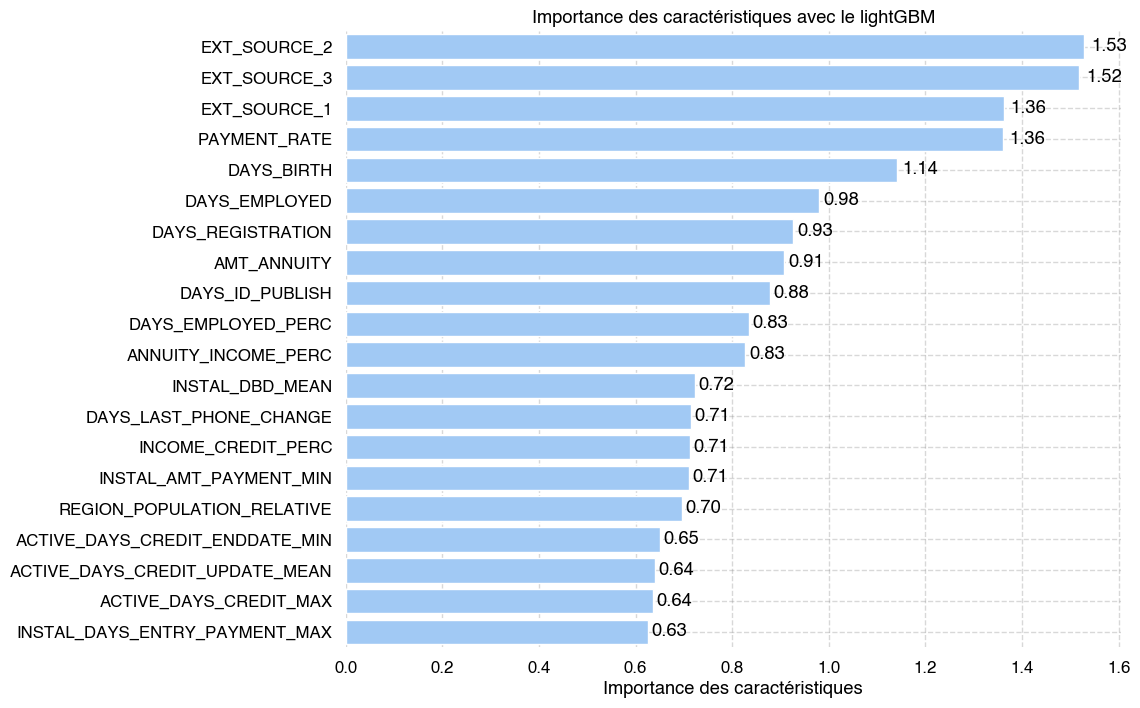

In [45]:
# Extraire les colonnes 'feature' et 'importance' de votre dataframe
features = df_feature_importances_lightGBM['feature'].to_numpy()
importances = df_feature_importances_lightGBM['importance'].to_numpy()

# Création d'un masque pour les importances supérieures à 0
mask = importances > 0

# Filtrage des features et des importances en utilisant le masque
filtered_feature_names = features[mask]
filtered_feature_importances = importances[mask]

# Supposons que vous vouliez afficher les 10 principales caractéristiques
n_features_to_display = 20

# Tri des indices filtrés par importance
sorted_idx = filtered_feature_importances.argsort()

# Limiter aux n principales caractéristiques
top_n_idx = sorted_idx[-n_features_to_display:]

# Affichage de l'importance des caractéristiques filtrées pour les n principales
plt.figure(figsize=(10, len(top_n_idx) * 0.4))
bars = plt.barh(filtered_feature_names[top_n_idx], filtered_feature_importances[top_n_idx])

# Ajuster les limites de l'axe des y pour réduire l'espace autour des barres
plt.ylim(-0.5, len(top_n_idx)-0.5)

plt.xlabel("Importance des caractéristiques")
plt.title("Importance des caractéristiques avec le lightGBM")

# Ajouter les valeurs à côté des barres
for bar in bars:
    width = bar.get_width()
    
    # Déterminez le formatage en fonction de la magnitude
    if width < 0.01:
        fmt = '{:.4f}'
    elif width < 0.1:
        fmt = '{:.3f}'
    else:
        fmt = '{:.2f}'
    
    plt.text(width + 0.01 * width,  # Ajouter un padding proportionnel à la valeur
             bar.get_y() + bar.get_height() / 2,
             fmt.format(width),
             va='center', ha='left')

plt.show()

Apparament, il n'y a pas de problème de data leaking car il n'y a pas de caractéristiques vraiment supérieures relatif aux autres

# Création modèle StandardScaler

In [46]:
application_train = df.dropna(subset=['TARGET']).drop(columns=['SK_ID_CURR','TARGET'])

scaler = StandardScaler()

# Ajuste le scaler à vos données d'entraînement
scaler.fit(application_train)

# Sauvegarde le scaler pour une utilisation ultérieure
joblib.dump(scaler, "../Simulations/Scaler/StandardScaler.pkl")

['../Simulations/Scaler/StandardScaler.pkl']